## 不考虑ORF calling的过滤，因为这样会得到更多的节点、
这样可能会导致一些和human proteome一样的ORF，短的ORF，重复的，做到自己心里有数，提取一个小的用于实验的表

In [5]:
import pandas as pd

def read_fasta_ids(fasta_path):
    """Read IDs from FASTA file"""
    ids = set()
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith('>'):
                id_ = line.strip()[1:].split('\t')[0]
                ids.add(id_)
    return ids

def read_file_ids(file_path, id_column='isoform_id', separator='\t'):
    """Read IDs from TSV file"""
    df = pd.read_csv(file_path, sep=separator, low_memory=False)
    if id_column == "transcript_id":
        ids = set()
        for id_str in df[id_column].dropna():
            ids.update(id_str.split(","))
        return ids
    return set(df[id_column].dropna())

def main():
    # File paths
    file1_path = "/cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/02_translatome_riboseq/03_cal_merge_A132_A133/001.A132_loose_detect_ORF_id.tsv"
    file2_path_1 = "/cpu2/jiang_tao/13.3Disoform/03_filter_parameter/01_filter_proteome/mmseqs2_longestORF_proteome/02_reference_proteome/orfanage/filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928.tsv"
    file4_path = "/cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/04_protein_structure/01_predicted_protein_structure/02_length_plddt/004.key_iso_plddt_over70_38016.tsv"
    proteome_plddt_path = "/cpu2/jiang_tao/13.3Disoform/04_pdb_predict_prepare_info/00_all_predict_pdb_structure/01_human_proteome/003.proteome_plddt_length.tsv"

    # Read IDs from files
    file1_ids = read_file_ids(file1_path, "transcript_id")
    file2_ids_1 = read_file_ids(file2_path_1)
    file4_ids = read_file_ids(file4_path, "Filename")

    # Find intersection of all sets with file2_path_1
    intersection_ids = file2_ids_1 & file1_ids & file4_ids

    # Read pLDDT data
    file4_df = pd.read_csv(file4_path, sep='\t')
    plddt_df = pd.read_csv(proteome_plddt_path, sep='\t')

    # Filter file4_df rows based on intersection
    matched_file4_df = file4_df[file4_df['Filename'].isin(intersection_ids)]

    # Filter proteome_pLDDT data with plddt >= 70
    filtered_plddt_df = plddt_df[plddt_df['plddt'] >= 70]

    # Combine matched rows with plddt >= 70 rows
    combined_df = pd.concat([matched_file4_df, filtered_plddt_df], ignore_index=True)

    # Save combined data to new file
    combined_df.to_csv('001.pdb_4network.tsv', sep='\t', index=False)
    
    print(f"Total IDs in output: {len(combined_df)}")
    print("Results saved to '001.pdb_4network.tsv'")

if __name__ == "__main__":
    main()

Total IDs in output: 46601
Results saved to '001.pdb_4network.tsv'


## cp pdb files

In [7]:
import os
import shutil
import pandas as pd

def copy_pdb_files(input_tsv, source_folders, target_folder):
    """
    Copy .pdb files listed in the Filename column of the input TSV file
    from the specified source folders to the target folder.
    """
    # Read the TSV file and get the list of filenames
    df = pd.read_csv(input_tsv, sep='\t')
    pdb_filenames = [f"{filename}.pdb" for filename in df['Filename'].dropna()]

    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Iterate over filenames and attempt to copy from each source folder
    for pdb_filename in pdb_filenames:
        found = False
        for source_folder in source_folders:
            pdb_path = os.path.join(source_folder, pdb_filename)
            if os.path.isfile(pdb_path):
                shutil.copy(pdb_path, target_folder)
                found = True
                break
        if not found:
            print(f"File not found in any source folder: {pdb_filename}")

    print(f"Copying complete. {len(pdb_filenames)} files processed.")

if __name__ == "__main__":
    # Define paths
    input_tsv = "001.pdb_4network.tsv"
    source_folders = [
        "/cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/04_protein_structure/01_predicted_protein_structure/01_all_pdb",
        "/cpu2/jiang_tao/13.3Disoform/04_pdb_predict_prepare_info/00_all_predict_pdb_structure/01_human_proteome/01_human_proteomes"
    ]
    target_folder = "02_pdb_over70"

    # Execute the function
    copy_pdb_files(input_tsv, source_folders, target_folder)


Copying complete. 46601 files processed.


In [8]:
import pandas as pd

# 文件路径
file_path = "001.pdb_4network.tsv"

# 读取文件
data = pd.read_csv(file_path, sep='\t')

# 检查 fasta_Length 和 protein_length 是否完全相同
length_mismatch = data[data['fasta_Length'] != data['protein_length']]
if not length_mismatch.empty:
    print("以下行的 fasta_Length 和 protein_length 不同：")
    print(length_mismatch[['fasta_Length', 'protein_length']])
else:
    print("fasta_Length 和 protein_length 完全相同。")

# 检查是否所有的 plddt >= 70
plddt_check = data['plddt'] >= 70
if plddt_check.all():
    print("所有的 plddt 都大于等于 70。")
else:
    print("以下行的 plddt 小于 70：")
    print(data[~plddt_check][['fasta_Length', 'protein_length', 'plddt']])
    


以下行的 fasta_Length 和 protein_length 不同：
       fasta_Length  protein_length
30897           NaN           118.0
30898           NaN           117.0
30899           NaN           120.0
30900           NaN            16.0
30901           NaN           120.0
...             ...             ...
46596           NaN           950.0
46597           NaN           936.0
46598           NaN           950.0
46599           NaN           948.0
46600           NaN           950.0

[15704 rows x 2 columns]
所有的 plddt 都大于等于 70。


### 001.pdb_4network.tsv file's pdb length and tsc PASS double check

pdb protein length = 001.pdb_4network.tsv 

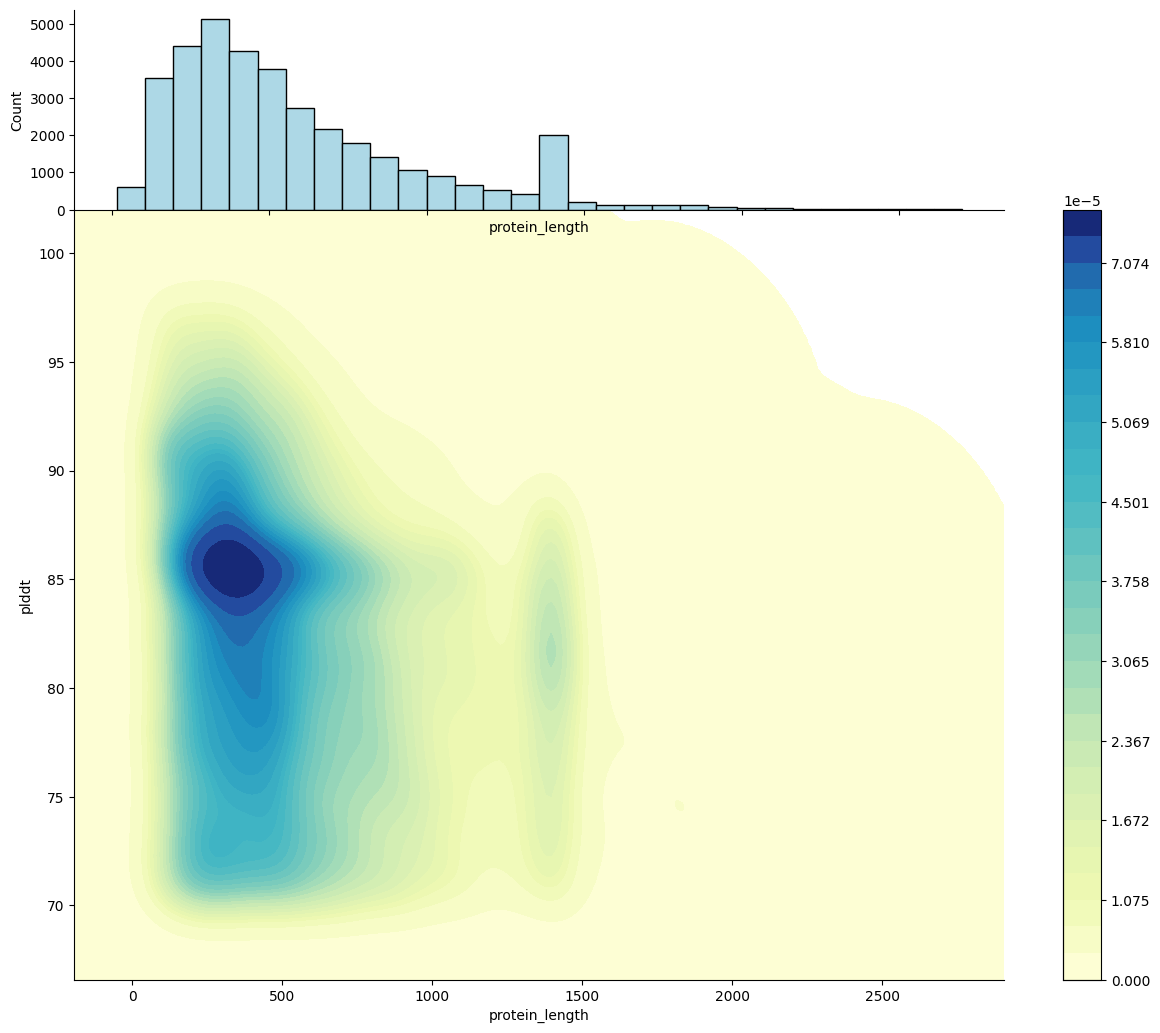

In [4]:
## 3. all

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv('001.pdb_4network.tsv', sep='\t')

# Set canvas size
fig, ax = plt.subplots(figsize=(15, 10))

# Draw the main density plot without legend with swapped x and y axes
sns.kdeplot(data=df, y='plddt', x='protein_length', fill=True, cmap='YlGnBu', levels=30, thresh=0, cbar=True, ax=ax)

# Draw additional histogram plot - top
ax_top = plt.axes([ax.get_position().x0, ax.get_position().y1, ax.get_position().width, 0.2], facecolor='none')
sns.histplot(data=df, x='protein_length', color='lightblue', bins=30, ax=ax_top, alpha=1, edgecolor='black')
# ax_top.set(xlabel='Count')
ax_top.tick_params(labelbottom=False)
ax_top.grid(False)

# Set title and axis labels
# plt.xlabel('Average plddt')
# plt.ylabel('Protein Length')

# Remove legend if present
legend = ax.get_legend()
if legend:
    legend.remove()

# Remove grid lines
sns.despine()

# Save the image with higher resolution and larger size
plt.savefig('001.pdb_over70_4network.png', dpi=300, bbox_inches='tight')  # Adjust dpi and figsize as needed

# Show the plot
plt.show()
